# 03 Bayesian Inference

Author: Murthadza Aznam <br/>
Date: 4th August 2021<br/>

This Notebook is written as part of the International Virtual Conference on Astrostatistics and Machine Learning (IVCASML2021) course.

---

## 0.0 GOAL
We are going to infer the distance of stars using their parallax with their errors. The inference method to used is Bayesian Inference with two different priors:
1. Uniform Distance Prior
2. Exponentially Decreasing Space Density Prior

---

## 1.0 PREPARATION

### 1.1 DATA PREPARATION
The data that is used in this notebook is from Gaia Early Data Release 3 (Gaia EDR3). The information that we need is the parallax and the parallax error.

We sample 10 stars from the list.

In [33]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.stats as stats
import scipy.integrate as integrate
import scipy.interpolate as interpolate

%matplotlib inline

In [42]:
DATAPATH = 'dataset'
OUTPUTPATH = 'output'

DATADIR = os.path.join('..', DATAPATH ,'gaia_edr3_selected.csv')

df = pd.read_csv(DATADIR)

seed = 146 #So that the random samples are reproducible

data = df.sample(n=10, random_state=seed)
data

,source_id,ra,dec,l,b,parallax_corr,pmra,pmdec,phot_g_mean_mag_corr,phot_bp_mean_mag,...,phot_rp_mean_flux_error,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,bp_rp,qg_geo,gq_photogeo
84381,5913245109818962560,259.280849,-63.188261,328.180854,-14.263654,0.396162,-2.431157,-10.542562,16.680500,17.115921,...,6.005934,2585.231450,2287.547120,2959.955320,2575.719240,2274.084960,2881.053220,1.026922,4.618003,4.626007
35523,6783544842784110976,322.028192,-31.529486,14.524666,-45.855646,0.477799,4.721973,-5.311352,19.554558,20.383732,...,10.191816,2153.633300,1342.150270,3561.866940,2367.657960,1863.933840,2731.450680,1.676514,7.892264,7.686528
42808,5924457310944293504,256.612147,-51.757463,336.907856,-6.574604,0.379517,-2.659232,-5.493267,20.120382,20.756033,...,6.299173,6971.676270,3577.723140,13367.841800,5660.481930,4847.357420,6826.362790,1.419289,5.903801,6.356220
77225,5911978987820459392,267.021484,-60.121933,332.824212,-15.924996,0.244464,-5.239246,-5.513691,16.304068,16.596571,...,9.567185,4396.941890,3668.409180,5424.634770,3449.806150,2999.101560,4001.355960,0.741152,3.088314,3.615094
86290,6411850921219623552,332.139305,-56.945099,335.482952,-48.598797,0.096645,-1.309562,-6.097585,20.650043,21.420792,...,6.983858,1701.790530,1052.081300,2541.297120,3791.313720,3036.279540,4401.412600,1.663891,9.498891,7.759473
77941,5919306236377734528,263.320154,-56.881010,334.786014,-12.666061,-1.370048,2.021974,-1.916540,20.018436,20.719673,...,4.005173,6637.002440,4016.623290,10409.519500,4912.184570,4232.867680,5739.495120,1.376047,5.908186,6.561672
81953,6652109188444127744,270.768693,-56.318818,337.278201,-16.025107,1.670942,6.298098,-9.448113,17.899658,19.083740,...,8.375607,611.659851,569.224976,657.166809,603.862122,567.264709,646.333496,2.264130,8.967108,8.994969
56848,4057962410679076480,261.837684,-31.471042,355.739079,1.962374,0.970146,3.516074,-6.875553,15.894626,16.521873,...,24.242790,1036.945190,988.128174,1098.608890,1036.479130,983.989746,1084.563600,1.419139,5.815847,5.816823
12095,5923084738156723200,260.199677,-54.871349,335.573491,-10.115688,0.228485,-1.912632,-4.700566,16.046091,16.711828,...,7.888793,4852.163570,3952.730710,6248.319340,4531.477050,3763.221190,5844.899410,1.452087,2.616414,2.764892
97339,6415146844763954560,281.768359,-73.842572,320.913146,-25.674411,0.976034,0.096225,-0.336277,20.712698,20.798632,...,6.452656,3983.074220,1367.145870,5640.334470,13256.955100,2847.412110,16966.789100,0.841894,7.707816,5.096689


In [43]:
star_id = data.index
parallax = data['parallax_corr'].to_numpy()
error = data['parallax_error'].to_numpy()

## 2.0 BAYESIAN INFERENCE
The probability of a star having a certain value given the parallax and parallax error is given by: $$P(r|\varpi, \sigma_\varpi) =\frac{1}{Z} P(\varpi | r, \sigma_\varpi)P(r)$$ WHERE $P(\varpi | r, \sigma_\varpi)$ is the likelihood, $P(r)$ is the prior probability, and $Z$ is the normalization constant. The resulting probability  $P(r| \varpi, \sigma_\varpi)$ is the posterior probability.

### 2.1 LIKELIHOOD FUNCTION
The likelihood function for this defined by: $$P\left(\varpi \mid r, \sigma_{\varpi}\right)=\frac{1}{\sqrt{2 \pi} \sigma_{\varpi}} \exp \left[-\frac{1}{2 \sigma_{\varpi}^{2}}\left(\varpi-\frac{1}{r}\right)^{2}\right], \sigma_{\varpi} \geq 0$$

In [44]:
def likelihood(parallax, error, distance):
    diff = parallax - (1/distance)
    exponent = np.exp(-(1/(2*(error**2)))*(diff**2))
    norm = 1/(np.sqrt(2*np.pi)*error)
    return norm*exponent

In [45]:
r_start = 0.1
r_lim = 10
sample_size=1000

r = np.linspace(r_start,r_lim,num=sample_size)

dr = (r_lim-r_start)/sample_size

### 2.2 PRIOR PROBABILITY
There are two priors that we are testing in this notebook:
1. Uniform distance prior: $$P(r) = \frac{1}{r_\text{lim}}, 0 < r \leq r_\text{lim};\, \text{(otherwise, P(r) = 0)}$$
2. Exponentially decreasing space density prior: $$P(r) = \frac{1}{2L^3}r^2\exp{\left(-\frac{r}{L}\right)}, r > 0;\, \text{(otherwise, P(r)=0)}$$ WHERE $L=1.35$ is the scale length chosen for this notebook.

In [46]:
def uni_dist(distance, max_distance):
    """Uniform Distance Prior
    """
    if (distance <= max_distance) and (distance>0):
        value = (1/max_distance)
    else:
        value = 0
    return value

def exp_dsd(distance):
    """Exponentially Decreasing Space Density Prior
    """
    L = 1.35 # 1.35 kpc scale length
    exponent = np.exp(-(distance/L))
    norm = (1/(2*L**3))*(distance**2)
    if distance > 0:
        value = norm*exponent
    else:
        value = 0
    return value

def post_uni(distance, parallax, error, max_distance):
    """The posterior for uniform distance prior
    """
    return uni_dist(distance, max_distance)*likelihood(parallax, error, distance)

def post_exp(distance, parallax, error, max_distance):
    """The posterior for exponentially decrasing space density prior
    """
    return exp_dsd(distance)*likelihood(parallax, error, distance)

### 2.3 CALCULATING MEAN, MODE AND INTERVAL

In [47]:
def CDF(x, y):
    """Return the cumulative density function to find mode and interval
    """
    func = interpolate.interp1d(x, y)
    cdf_at_x = list()
    for i, k in enumerate(y):
        if i == 0:
            cdf_at_x.append(k)
        else:
            cdf_at_x.append(k + cdf_at_x[i-1])
    return cdf_at_x

def cutoff(cutoff,star, cdf):
    """Return the index number of the one in the cutoff of choice
    """
    index = list()
    length = 0
    printed = False
    n = int()
    for i, j in enumerate(cdf[star]):
        length += 1
        if round(j, 2) == cutoff:
            index.append(i)
        elif (round(j,2) >= cutoff - 0.01) and (round(j,2) <= cutoff + 0.01):
            index.append(i)
        if length != len(index) and len(index) and printed == False:
            n = sum(index)/len(index)
            printed = True
    return int(n)

"""PART I: UNIFORM DENSITY PRIOR
"""

y_uni = dict()
mean_uni = dict()
mode_uni = dict()
cdf_uni = dict()

for i, star in enumerate(star_id):
    y_uni[star] = list()
    cdf_uni[star] = list()
    
    for distance in r:
        func = post_uni(distance, parallax[i], error[i], r_lim)
        y_uni[star].append(func)
    
    Z_uni = interpolate.interp1d(r, y_uni[star])
    Z = sum(Z_uni(r))
    y_uni[star] = y_uni[star]/Z
    
    mean_uni[star] = sum(y_uni[star]*r)
    mode_uni[star] = np.where(y_uni[star] == max(y_uni[star]))
    cdf_uni[star] = CDF(r, y_uni[star])


"""PART II: EXPONENTIALLY DECREASING SPACE DENSITY PRIOR
"""

y_exp = dict()
mean_exp = dict()
mode_exp = dict()
cdf_exp = dict()

for i, star in enumerate(star_id):
    y_exp[star] = list()
    cdf_exp[star] = list()
#    Z_exp = integrate.quad(post_exp(parallax[i], error[i], r_lim), 0, r_lim)
    
    for distance in r:
        y_exp[star].append(post_exp(distance, parallax[i], error[i], r_lim))
    
    Z_exp = interpolate.interp1d(r, y_exp[star])
    Z = sum(Z_exp(r))
    y_exp[star] = y_exp[star]/Z
    
    mean_exp[star] = sum(y_exp[star]*r)/sum(y_exp[star])
    mode_exp[star] = np.where(y_exp[star] == y_exp[star].max())
    cdf_exp[star] = CDF(r, y_exp[star])    

## 3.0 PLOTTING

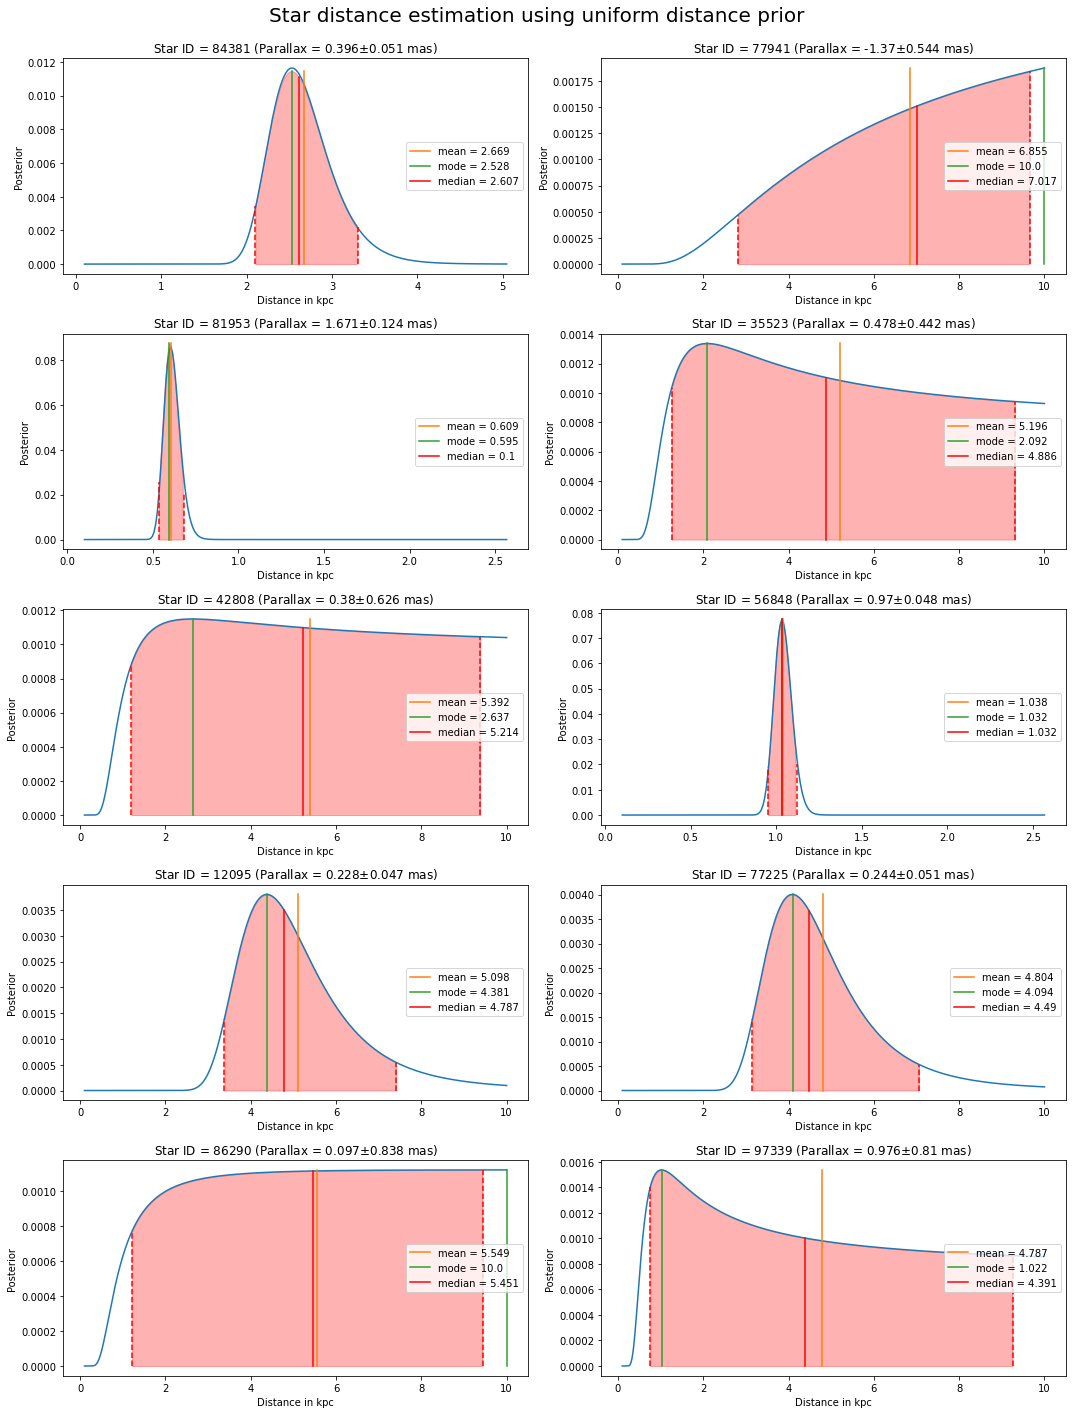

In [48]:
sig_fig = 3
fig, axs = plt.subplots(5,2, figsize=(15,20))
i = 0
j = 0    
for k, star in enumerate(star_id):
    mean = mean_uni[star]
    
    mode_idx = mode_uni[star][0]
    median_idx = cutoff(0.50, star, cdf_uni)
    top_idx = cutoff(0.95, star, cdf_uni)
    low_idx = cutoff(0.05, star, cdf_uni)
    
    title = "Star ID = " + str(star) + " (Parallax = " + str(round(parallax[k],sig_fig)) + r"$\pm$" + str(round(error[k],sig_fig)) + " mas)"
    
    if top_idx < int(sample_size/4):
        axs[i,j].plot(r[0:int(sample_size/4)],y_exp[star][0:int(sample_size/4)])
    elif top_idx < int(sample_size/2):
        axs[i,j].plot(r[0:int(sample_size/2)],y_exp[star][0:int(sample_size/2)])
    else:
        axs[i,j].plot(r, y_uni[star])
    
    axs[i,j].plot([mean,mean], [0,max(y_uni[star])], label="mean = "+ str(round(mean, sig_fig)))
    axs[i,j].plot([r[mode_idx],r[mode_idx]], [0,max(y_uni[star])], label="mode = "+ str(round(r[mode_idx][0], sig_fig)))
    
    axs[i,j].plot([r[median_idx],r[median_idx]], [0, y_uni[star][median_idx]], label="median = "+ str(round(r[median_idx], sig_fig)), color="red")
    axs[i,j].plot([r[top_idx],r[top_idx]], [0, y_uni[star][top_idx]], '--', color="red")
    axs[i,j].plot([r[low_idx],r[low_idx]], [0, y_uni[star][low_idx]], '--', color="red")
    
    x_between = r[low_idx:top_idx]
    y_between = y_uni[star][low_idx:top_idx]
    
    axs[i,j].fill_between(x_between,y_between, color=(1,0,0,0.3))
    
    axs[i,j].set_title(title)
    axs[i,j].set_xlabel('Distance in kpc')
    axs[i,j].set_ylabel('Posterior')
    axs[i,j].legend(loc="right")
    
    if j == 1:
        j = 0
    else:
        j += 1
    if i == 4:
        i = 0
    else:
        i += 1
fig.suptitle("Star distance estimation using uniform distance prior\n", fontsize=20)
fig.tight_layout()
fig.savefig(os.path.join('..', OUTPUTPATH, "03BI post_uni.jpg"))

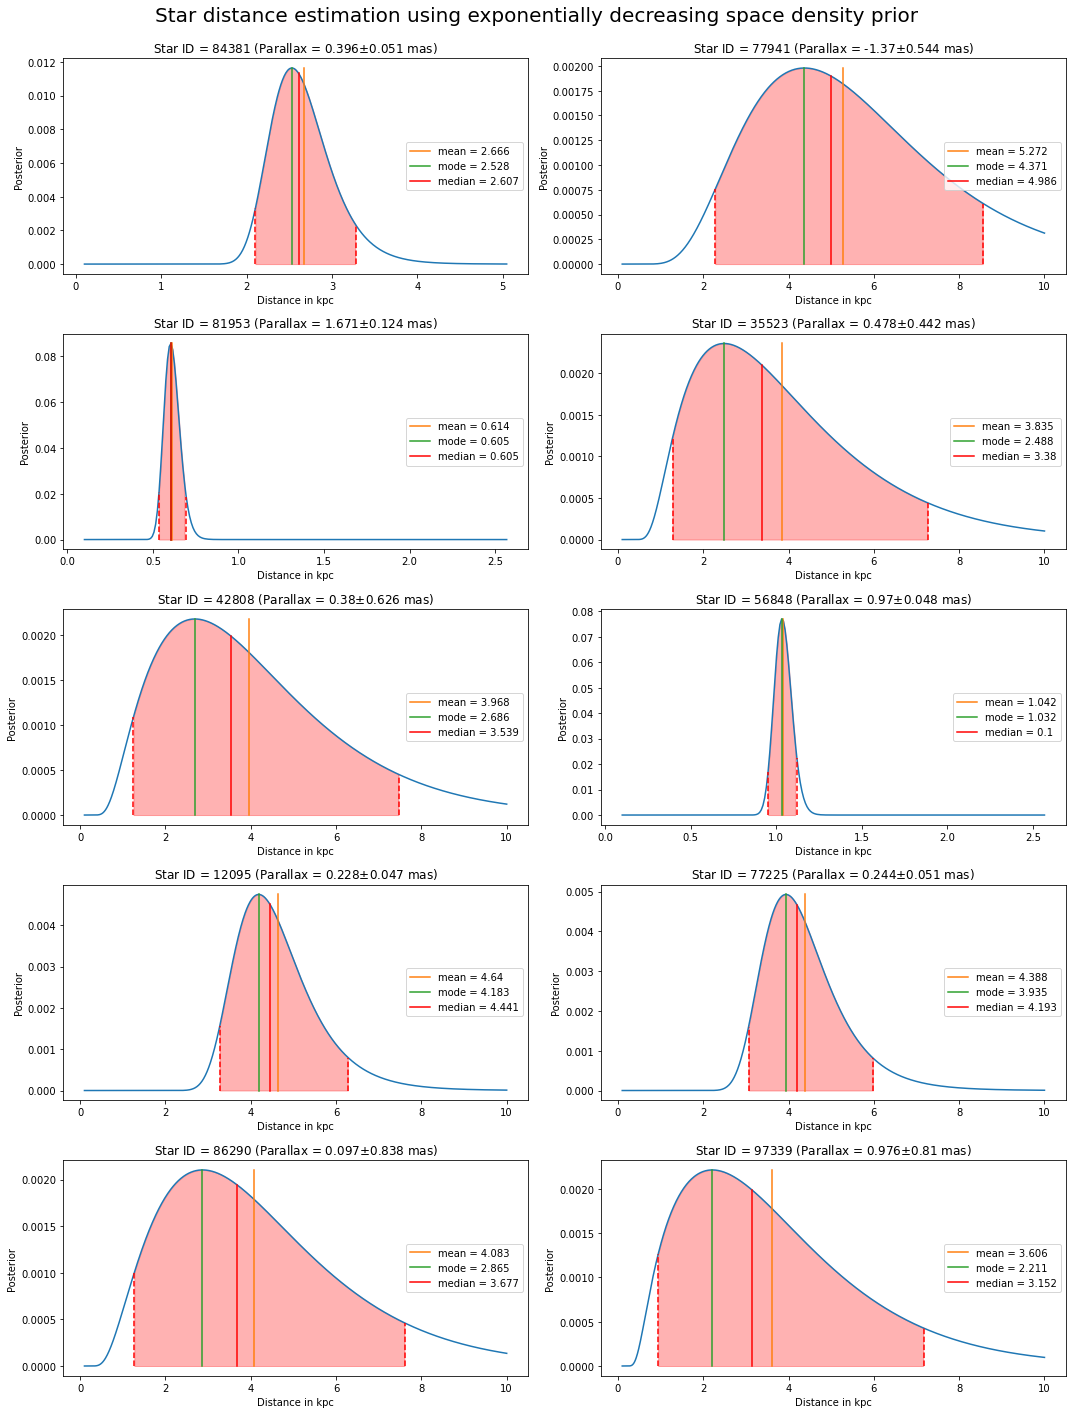

In [49]:
fig, axs = plt.subplots(5,2, figsize=(15,20))
i = 0
j = 0
for k, star in enumerate(star_id):
    mean = mean_exp[star]
    
    mode_idx = mode_exp[star][0]
    median_idx = cutoff(0.50, star, cdf_exp)
    top_idx = cutoff(0.95, star, cdf_exp)
    low_idx = cutoff(0.05, star, cdf_exp)
    
    title = "Star ID = " + str(star) + " (Parallax = " + str(round(parallax[k],sig_fig)) + r"$\pm$" + str(round(error[k],sig_fig)) + " mas)"
    
    if top_idx < int(sample_size/4):
        axs[i,j].plot(r[0:int(sample_size/4)],y_exp[star][0:int(sample_size/4)])
    elif top_idx < int(sample_size/2):
        axs[i,j].plot(r[0:int(sample_size/2)],y_exp[star][0:int(sample_size/2)])
    else:
        axs[i,j].plot(r, y_exp[star])
    axs[i,j].plot([mean,mean], [0,max(y_exp[star])], label="mean = "+ str(round(mean, sig_fig)))
    axs[i,j].plot([r[mode_idx],r[mode_idx]], [0,max(y_exp[star])], label="mode = "+ str(round(r[mode_idx][0], sig_fig)))
    
    axs[i,j].plot([r[median_idx],r[median_idx]], [0, y_exp[star][median_idx]], label="median = "+ str(round(r[median_idx], sig_fig)), color="red")
    axs[i,j].plot([r[top_idx],r[top_idx]], [0, y_exp[star][top_idx]], '--', color="red")
    axs[i,j].plot([r[low_idx],r[low_idx]], [0, y_exp[star][low_idx]], '--', color="red")
    
    x_between = r[low_idx:top_idx]
    y_between = y_exp[star][low_idx:top_idx]
    
    axs[i,j].fill_between(x_between,y_between, color=(1,0,0,0.3))
    
    axs[i,j].set_title(title)
    axs[i,j].set_xlabel("Distance in kpc")
    axs[i,j].set_ylabel("Posterior")
    axs[i,j].legend(loc="right")
    if j == 1:
        j = 0
    else:
        j += 1
    if i == 4:
        i = 0
    else:
        i += 1
fig.suptitle("Star distance estimation using exponentially decreasing space density prior\n", fontsize=20)
fig.tight_layout()
fig.savefig(os.path.join('..', OUTPUTPATH, "03BI post_exp.jpg"))

# APPENDIX A
1. The formula used in the calculation of posteriors and priors are taken from "Tri L. Astraatmadja and Coryn A. L. Bailer-Jones 2016 _ApJ_ **832** 137 doi:[10.3847/0004-637X/832/2/137](https://iopscience.iop.org/article/10.3847/0004-637X/832/2/137)". The formula list can be found in table 2.